In [19]:
# Imports
import numpy as np
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
from master_data_functions.functions import *
from keras import backend
%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Load data
DATA_PATH = "../../data/simulated/"
OUTPUT_PATH = "../../data/output/"
MODEL_PATH = OUTPUT_PATH + "models/"


# Images are NOT normalized, positions are normalized (div by 16) to [0,1] interal
images = np.load(DATA_PATH + "test_images_double_1M.npy")
#energies = np.load(DATA_PATH + "test_energies_double_1M.npy")
positions = np.load(DATA_PATH + "test_positions_double_1M.npy")

# shape is (x1, y1, x2, y2, E1, E2)
y_pred = np.load(DATA_PATH + "test_y_pred_double_1M.npy")


print("Images shape: {}".format(images.shape))
#print("Energies shape: {}".format(energies.shape))
#print("Positions shape: {}".format(positions.shape))
print("Targets shape: {}".format(targets.shape))
print("Predictions shape: {}".format(y_pred.shape))

Images shape: (100000, 16, 16, 1)
Targets shape: (100000, 4)
Predictions shape: (100000, 4)


In [12]:
# Custom functions
# Define R2 score in numpy
eps = 1e-13
def r2_score(y_true, y_pred):
    SS_res =  np.sum(np.square(y_true - y_pred))
    SS_tot = np.sum(np.square(y_true - np.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + eps) )


In [13]:
# Statistics about the data
single, double, close = event_indices(positions*16*3) #scale to mm

print("Number of single events:", len(single))
print("Number of double events:", len(double))
print("Number of close events:", len(close))

Number of single events: 0
Number of double events: 100000
Number of close events: 514


In [14]:
# Get some numbers about the residuals for double events

y_resid = positions - y_pred

print("X1 residuals mean: {:g}".format(np.mean(y_resid[double,0])))
print("Y1 residuals mean: {:g}".format(np.mean(y_resid[double,1])))
print("X2 residuals mean: {:g}".format(np.mean(y_resid[double,2])))
print("Y2 residuals mean: {:g}".format(np.mean(y_resid[double,3])))
#print("E1 residuals mean: {:g}".format(np.mean(y_resid[double,4])))
#print("E2 residuals mean: {:g}".format(np.mean(y_resid[double,5])))

rel_dist = relative_distance(positions)
#rel_E = relative_energy(energies)

X1 residuals mean: 0.0248827
Y1 residuals mean: 0.000258145
X2 residuals mean: 0.00833432
Y2 residuals mean: 0.0146045


In [15]:
# Individual R2-scores for each target for double events
print("X1 r2 = {:g}".format(r2_score(targets[double, 0], y_pred[double, 0])))
print("Y1 r2 = {:g}".format(r2_score(targets[double, 1], y_pred[double, 1])))
print("X2 r2 = {:g}".format(r2_score(targets[double, 2], y_pred[double, 2])))
print("Y2 r2 = {:g}".format(r2_score(targets[double, 3], y_pred[double, 3])))
#print("E1 r2 = {:g}".format(r2_score(targets[double, 4], y_pred[double, 4])))
#print("E2 r2 = {:g}".format(r2_score(targets[double, 5], y_pred[double, 5])))

#print("Single events r2:", r2_score(targets[single], y_pred[single]))
print("Double events r2:", r2_score(targets[double], y_pred[double]))

X1 r2 = -0.115413
Y1 r2 = -0.111849
X2 r2 = -0.109499
Y2 r2 = -0.118448
Double events r2: -0.11381006376817937


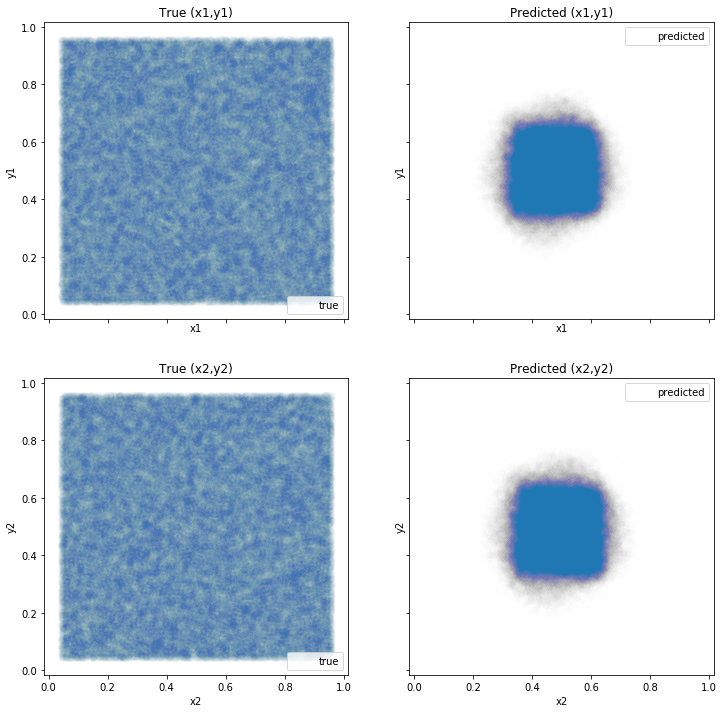

In [20]:
# Scatterplot predicted positions x1,y1 and target positions
fig, ax = plt.subplots(2,2, figsize=(12,12), sharex=True, sharey=True)
ax[0,0].scatter(targets[double,0], targets[double,1], alpha=0.01, label="true")
ax[0,0].set_title("True (x1,y1)")
ax[0,0].set_xlabel("x1")
ax[0,0].set_ylabel("y1")
ax[0,0].legend()

ax[0,1].scatter(y_pred[double,0], y_pred[double,1], alpha=0.005, label="predicted")
ax[0,1].set_title("Predicted (x1,y1)")
ax[0,1].set_xlabel("x1")
ax[0,1].set_ylabel("y1")
ax[0,1].legend()

ax[1,0].scatter(targets[double,2], targets[double,3], alpha=0.01, label="true")
ax[1,0].set_title("True (x2,y2)")
ax[1,0].set_xlabel("x2")
ax[1,0].set_ylabel("y2")
ax[1,0].legend()

ax[1,1].scatter(y_pred[double,2], y_pred[double,3], alpha=0.005, label="predicted")
ax[1,1].set_title("Predicted (x2,y2)")
ax[1,1].set_xlabel("x2")
ax[1,1].set_ylabel("y2")
ax[1,1].legend()
plt.show()
